#**AI-Enabled FinTech B2B Invoice Management Application**


####H2HBABBA2326_HouseAmy_AayushJain

##**MILESTONE 1 - Data Cleaning and Preprocessing**

In [1]:
#import required modules
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score

In [2]:
#load data from csv file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/H2HBABBA2326.csv', index_col=False)
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200700919,US,2019-03-04 00:00:00,2019.0,1.928662e+09,2019-01-31,20190122,20190131,20190304.0,USD,RV,1.0,NaN,32073.90,20190131.0,NA32,1.928662e+09,0
1,U001,0200714710,SYSCO,2019-02-13 00:00:00,2019.0,1.928689e+09,2019-01-28,20190126,20190128,20190212.0,USD,RV,1.0,NaN,23919.64,20190128.0,NAA8,1.928689e+09,0
2,U001,0200762301,C&S WH us,2019-07-15 00:00:00,2019.0,1.929556e+09,2019-06-28,20190628,20190628,20190713.0,USD,RV,1.0,NaN,48470.34,20190628.0,NAC6,1.929556e+09,0
3,U001,0200020431,DEC associates,2019-12-16 00:00:00,2019.0,1.930216e+09,2019-12-04,20191204,20191204,20191224.0,USD,RV,1.0,NaN,508.80,20191201.0,NAM4,1.930216e+09,0
4,U001,CCU013,KRAFT F trust,2019-03-29 00:00:00,2019.0,1.928846e+09,2019-02-26,20190222,20190226,20190226.0,USD,RV,1.0,NaN,1910.91,20190226.0,NAX2,1.928846e+09,0


In [3]:
df.shape

(50000, 19)

In [4]:
#Count the number of empty (NaN, NAN, na) vales in each column
df.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    2
isOpen                        0
dtype: int64

In [5]:
#store rows where clear_date is NaN/null to use it in test and drop them from original dataframe.
main_test = df.loc[df['isOpen']!=0]
main_test.reset_index(drop=True,inplace=True)
print("Test size:",main_test.shape)
df.dropna(subset=['clear_date'],how='any', axis=0, inplace=True)
print("Original size:",df.shape)

Test size: (10000, 19)
Original size: (40000, 19)


In [6]:
#droping columns with all null values i.e. area_business column
df.dropna(how='all', axis=1, inplace=True)
print(df.shape)
[col for col in df.columns if df[col].isnull().sum() > 0]

(40000, 18)


['invoice_id']

In [7]:
#Drop null values except clear_date to further process it and and split it to use it in test from the dataframe
df.dropna(subset=['invoice_id'],axis=0, inplace=True)
df.shape

(39998, 18)

In [8]:
#get the datatype of each column
df.dtypes

business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year             float64
doc_id                    float64
posting_date               object
document_create_date        int64
document_create_date.1      int64
due_in_date               float64
invoice_currency           object
document type              object
posting_id                float64
total_open_amount         float64
baseline_create_date      float64
cust_payment_terms         object
invoice_id                float64
isOpen                      int64
dtype: object

In [9]:
#Convert isOpen's int64 datatype to float64
df = df.astype({'isOpen':float})
main_test = main_test.astype({'isOpen' :float})
df.isOpen.dtype

dtype('float64')

In [10]:
# select all columns having float datatype
float_df = df.select_dtypes(include ='float64')
float_df.columns

Index(['buisness_year', 'doc_id', 'due_in_date', 'posting_id',
       'total_open_amount', 'baseline_create_date', 'invoice_id', 'isOpen'],
      dtype='object')

In [11]:
#fitting float datatype columns in Variance Threshold to find quasi-constant columns. 
qconst_filter = VarianceThreshold(threshold=0.1)
qconst_filter.fit(float_df)

print(len(float_df.columns[qconst_filter.get_support()]))

qconst_columns = [column for column in float_df.columns if column not in float_df.columns[qconst_filter.get_support()]]
qconst_columns

6


['posting_id', 'isOpen']

In [12]:
#drop the constant columns from the original dataframe
df.drop(columns=qconst_columns, inplace=True)
df.shape

(39998, 16)

In [13]:
#convert the dates into datetime datatype from object datatype
df['clear_date']= pd.to_datetime(df['clear_date'])
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['document_create_date'] = pd.to_datetime(df['document_create_date'], format="%Y%m%d")
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'], format="%Y%m%d")
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format="%Y%m%d")
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'], format="%Y%m%d")

In [14]:
#function to find duplicate columns
def findDuplicateColumns(df):
  duplicateColNames = set()
  for x in range(df.shape[1]):
    col1 = df.iloc[:, x]
    for y in range(x+1, df.shape[1]):
      col2 = df.iloc[:, y]
      if col1.equals(col2):
        duplicateColNames.add(df.columns[y])
  return list(duplicateColNames)

In [15]:
#if any duplicate column is found it will be droped
duplicateCols = findDuplicateColumns(df)
print(duplicateCols)
if(len(duplicateCols) > 0):
  df.drop(columns=duplicateCols, inplace=True)
df.shape

['document_create_date.1', 'invoice_id']


(39998, 14)

In [16]:
#find duplicate rows
duplicateRows = df[df.duplicated()]
duplicateRows

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms
694,U007,0100024767,GREEN foundation,2019-07-26,2019.0,1.929492e+09,2019-06-14,2019-06-14,2019-07-19,USD,RV,3315.44,2019-06-14,NAG2
1560,U001,0200769623,WAL-MAR associates,2019-03-14,2019.0,1.928887e+09,2019-03-04,2019-03-02,2019-03-19,USD,RV,48441.09,2019-03-04,NAH4
1719,U001,0200718130,SYSCO F in,2019-07-31,2019.0,1.929595e+09,2019-07-09,2019-07-09,2019-07-29,USD,RV,15208.28,2019-07-09,NAD1
2647,U001,0200943275,US associates,2019-10-18,2019.0,1.929946e+09,2019-10-02,2019-10-01,2019-10-17,USD,RV,63074.04,2019-10-02,NAA8
2878,U001,0200769623,WAL-MAR llc,2019-10-07,2019.0,1.929897e+09,2019-09-20,2019-09-19,2019-10-05,USD,RV,60506.62,2019-09-20,NAH4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49790,U001,0200769623,WAL-MAR foundation,2019-08-27,2019.0,1.929758e+09,2019-08-17,2019-08-17,2019-09-01,USD,RV,4682.46,2019-08-17,NAH4
49837,U001,0200689451,PORK llc,2019-12-18,2019.0,1.930217e+09,2019-12-05,2019-12-04,2019-12-20,USD,RV,195946.84,2019-12-05,NAA8
49912,U001,0200769623,WAL-MAR llc,2019-06-06,2019.0,1.929346e+09,2019-05-20,2019-05-19,2019-06-04,USD,RV,537.09,2019-05-20,NAH4
49955,U001,0200895843,US corporation,2019-03-25,2019.0,1.928901e+09,2019-03-05,2019-03-05,2019-03-25,USD,RV,318.80,2019-03-05,NAD1


In [17]:
#remove duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(39141, 14)

In [18]:
#finding out the number of distinct values in each columns
df.nunique()

business_code               6
cust_number              1342
name_customer            3962
clear_date                401
buisness_year               2
doc_id                  39141
posting_date              424
document_create_date      425
due_in_date               496
invoice_currency            2
document type               1
total_open_amount       35609
baseline_create_date      431
cust_payment_terms         71
dtype: int64

In [19]:
#drop other primary key (unique values same as number of rows) and constant columns (unique value is only 1)
df.drop(columns=['doc_id', 'document type'], inplace=True)
df.shape

(39141, 12)

In [20]:
#checking the datatypes
df.dtypes

business_code                   object
cust_number                     object
name_customer                   object
clear_date              datetime64[ns]
buisness_year                  float64
posting_date            datetime64[ns]
document_create_date    datetime64[ns]
due_in_date             datetime64[ns]
invoice_currency                object
total_open_amount              float64
baseline_create_date    datetime64[ns]
cust_payment_terms              object
dtype: object

##**MILSTONE 2 - EDA and Feature Engineering**

In [21]:
#removing the outlier of due date of invoice being less than then document create date of invoice (not possible) 
df = df[~(df['document_create_date']>df['due_in_date'])]
df.shape

(39023, 12)

In [22]:
#sort the dataset in ascending order of the posting date of invoice
df.sort_values(by=['posting_date'],  inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,U001,0200772670,ASSOCIAT foundation,2019-01-15,2019.0,2018-12-30,2018-12-30,2019-01-14,USD,98118.31,2018-12-30,NAU5
1,U001,0200769623,WAL-MAR associates,2019-01-09,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,4890.99,2018-12-30,NAH4
2,U001,0200707005,KING S associates,2019-01-14,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,48395.73,2018-12-30,NAA8
3,U001,0100001196,DOLLAR corporation,2019-01-18,2019.0,2018-12-30,2018-12-31,2019-01-14,USD,671.90,2018-12-30,NAA8
4,U001,0200759878,SA,2019-01-15,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,14639.07,2018-12-30,NAH4


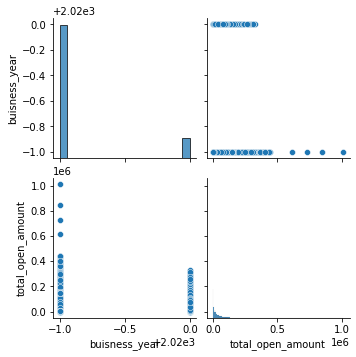

In [23]:
#visualizing replationship between various columns 
sns.pairplot(df, diag_kind="hist")

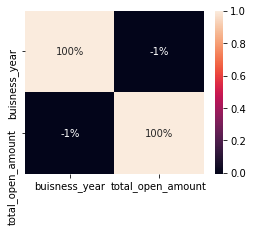

In [24]:
#Visualize the correlation
plt.figure(figsize=(4, 3))
sns.heatmap(df.corr(), annot=True, fmt='.0%')

In [25]:
#check if there is any outlier of baseline create date greater than due in date.
df[(df['baseline_create_date']>df['due_in_date'])].shape

(0, 12)

In [26]:
#calculating number of days from baseline_create_date to due_in_date provided.
df['expected_clear_days'] = (df['due_in_date'].sub(df['baseline_create_date'], axis=0)).dt.days
df.head(3)

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,expected_clear_days
0,U001,0200772670,ASSOCIAT foundation,2019-01-15,2019.0,2018-12-30,2018-12-30,2019-01-14,USD,98118.31,2018-12-30,NAU5,15
1,U001,0200769623,WAL-MAR associates,2019-01-09,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,4890.99,2018-12-30,NAH4,15
2,U001,0200707005,KING S associates,2019-01-14,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,48395.73,2018-12-30,NAA8,15


In [27]:
#get count of unique values of dataset
df.nunique()

business_code               6
cust_number              1341
name_customer            3959
clear_date                400
buisness_year               2
posting_date              423
document_create_date      425
due_in_date               493
invoice_currency            2
total_open_amount       35504
baseline_create_date      429
cust_payment_terms         71
expected_clear_days        29
dtype: int64

In [28]:
#As there are only 6 unique values we can perform one hot encoding technique on business code column
business_dummies = pd.get_dummies(df.business_code)
business_dummies.head()

,CA02,U001,U002,U005,U007,U013
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [29]:
#merging the new dummy variables with the original dataset
df = pd.concat([df, business_dummies], axis='columns')
df.head(3)

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,expected_clear_days,CA02,U001,U002,U005,U007,U013
0,U001,0200772670,ASSOCIAT foundation,2019-01-15,2019.0,2018-12-30,2018-12-30,2019-01-14,USD,98118.31,2018-12-30,NAU5,15,0,1,0,0,0,0
1,U001,0200769623,WAL-MAR associates,2019-01-09,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,4890.99,2018-12-30,NAH4,15,0,1,0,0,0,0
2,U001,0200707005,KING S associates,2019-01-14,2019.0,2018-12-30,2018-12-29,2019-01-14,USD,48395.73,2018-12-30,NAA8,15,0,1,0,0,0,0


In [30]:
#drop the any one of the the dummy columns to avoid Dummy Variable Trap
df.drop(columns=['U013'], inplace=True)
df.shape

(39023, 18)

In [31]:
#Use LabelEncoder to encode unique customer name due to large number of distinct columns
df.drop(columns=['cust_number'], inplace=True)
name_cust_encoder = LabelEncoder()
df['name_customer_enc'] = name_cust_encoder.fit_transform(df['name_customer'])

invoice_curr_encoder = LabelEncoder()
df["invoice_currency_enc"] = invoice_curr_encoder.fit_transform(df["invoice_currency"])

cust_payterm_encoder = LabelEncoder()
df["cust_payment_terms_enc"] = cust_payterm_encoder.fit_transform(df["cust_payment_terms"])

df.drop(columns=['name_customer','invoice_currency','cust_payment_terms'], inplace=True)
df.head(3)

,business_code,clear_date,buisness_year,posting_date,document_create_date,due_in_date,total_open_amount,baseline_create_date,expected_clear_days,CA02,U001,U002,U005,U007,name_customer_enc,invoice_currency_enc,cust_payment_terms_enc
0,U001,2019-01-15,2019.0,2018-12-30,2018-12-30,2019-01-14,98118.31,2018-12-30,15,0,1,0,0,0,235,1,50
1,U001,2019-01-09,2019.0,2018-12-30,2018-12-29,2019-01-14,4890.99,2018-12-30,15,0,1,0,0,0,3829,1,37
2,U001,2019-01-14,2019.0,2018-12-30,2018-12-29,2019-01-14,48395.73,2018-12-30,15,0,1,0,0,0,1964,1,22


In [32]:
#calculating delay in no of days from clear date to provided due date which will act as our target
df['delay'] = (df['clear_date'].sub(df['due_in_date'], axis=0)).dt.days
df.delay

0        1
1       -5
2        0
3        4
4        1
        ..
39018    0
39019    0
39020   -1
39021   -2
39022   -1
Name: delay, Length: 39023, dtype: int64

In [33]:
#getting the mean of delays for each business code available
business_delay_dict = df.groupby('business_code')['delay'].mean().to_dict()
business_delay_dict

{'CA02': 5.927377892030848,
 'U001': 0.23929392400034055,
 'U002': 5.664,
 'U005': 15.307692307692308,
 'U007': -3.5,
 'U013': 6.97378277153558}

In [34]:
#mapping each business average delay in the dataset
df['business_avg_delay'] = df['business_code'].map(business_delay_dict)

In [35]:
#getting the mean of delays for each customer and payment terms available
cust_delay_dict = df.groupby('name_customer_enc')['delay'].mean().to_dict()
payterm_delay_dict = df.groupby('cust_payment_terms_enc')['delay'].mean().to_dict()

In [36]:
#mapping each customer average delay and payment term average delay in the dataset
df['cust_avg_delay'] = df['name_customer_enc'].map(cust_delay_dict)
df['payterm_avg_delay'] = df['cust_payment_terms_enc'].map(payterm_delay_dict)

In [37]:
df.head(3)

,business_code,clear_date,buisness_year,posting_date,document_create_date,due_in_date,total_open_amount,baseline_create_date,expected_clear_days,CA02,U001,U002,U005,U007,name_customer_enc,invoice_currency_enc,cust_payment_terms_enc,delay,business_avg_delay,cust_avg_delay,payterm_avg_delay
0,U001,2019-01-15,2019.0,2018-12-30,2018-12-30,2019-01-14,98118.31,2018-12-30,15,0,1,0,0,0,235,1,50,1,0.239294,1.000000,1.131268
1,U001,2019-01-09,2019.0,2018-12-30,2018-12-29,2019-01-14,4890.99,2018-12-30,15,0,1,0,0,0,3829,1,37,-5,0.239294,-2.507299,-1.823894
2,U001,2019-01-14,2019.0,2018-12-30,2018-12-29,2019-01-14,48395.73,2018-12-30,15,0,1,0,0,0,1964,1,22,0,0.239294,0.375000,1.241112


In [38]:
#Get the maximum and minimum date from document create date in dataset find out where to split our dataset from
print(df['document_create_date'].max())
print(df['document_create_date'].min())

2020-02-27 00:00:00
2018-12-26 00:00:00


In [39]:
#Split 60% data in train dataset, 20% for validation and 20% for test dataset to furthur get preditions  
train, temp = train_test_split(df, test_size=0.4, random_state=0, shuffle=False)
val, test = train_test_split(temp, test_size=0.5, random_state=0, shuffle=False)
train.shape, val.shape, test.shape

((23413, 21), (7805, 21), (7805, 21))

In [40]:
#Reset the index for train, test and validation set
train.reset_index(drop=True,inplace=True)
val.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [41]:
#getting updated unique values 
train.nunique()

business_code                 6
clear_date                  265
buisness_year                 1
posting_date                245
document_create_date        248
due_in_date                 317
total_open_amount         21620
baseline_create_date        253
expected_clear_days          26
CA02                          2
U001                          2
U002                          2
U005                          2
U007                          2
name_customer_enc          3199
invoice_currency_enc          2
cust_payment_terms_enc       62
delay                       168
business_avg_delay            6
cust_avg_delay              846
payterm_avg_delay            55
dtype: int64

In [42]:
#Dropping constant columns respresented by 1
train.drop(columns = ['buisness_year'] , inplace = True)
val.drop(columns = ['buisness_year'] , inplace = True)
test.drop(columns = ['buisness_year'] , inplace = True)
train.shape, val.shape, test.shape

((23413, 20), (7805, 20), (7805, 20))

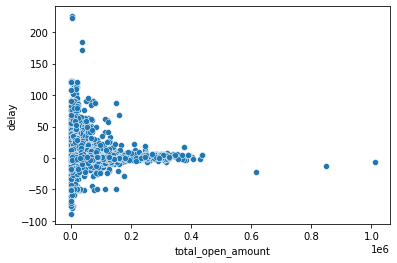

In [43]:
#visualize the relationship between the total open amount and delays 
sns.scatterplot(data=train, x="total_open_amount", y="delay")

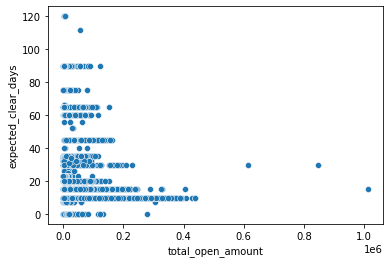

In [44]:
#visualize the relationship between the total open amount and expected clear days 
sns.scatterplot(data=train, x="total_open_amount", y="expected_clear_days")

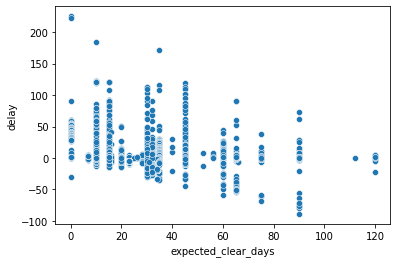

In [45]:
#visualize the relationship between the expeected clear days and delays 
sns.scatterplot(data=train, x="expected_clear_days", y="delay")

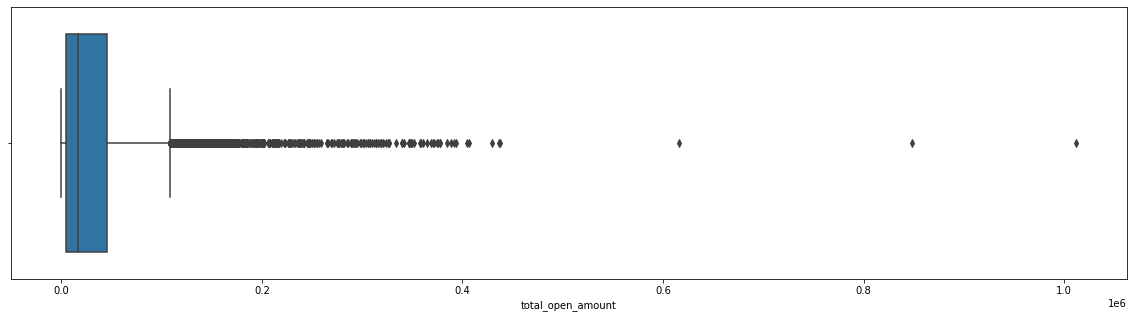

In [46]:
#visualize the distribution of quantitative data of total open amount
plt.figure(figsize=(20,5))
sns.boxplot(x=train['total_open_amount'])

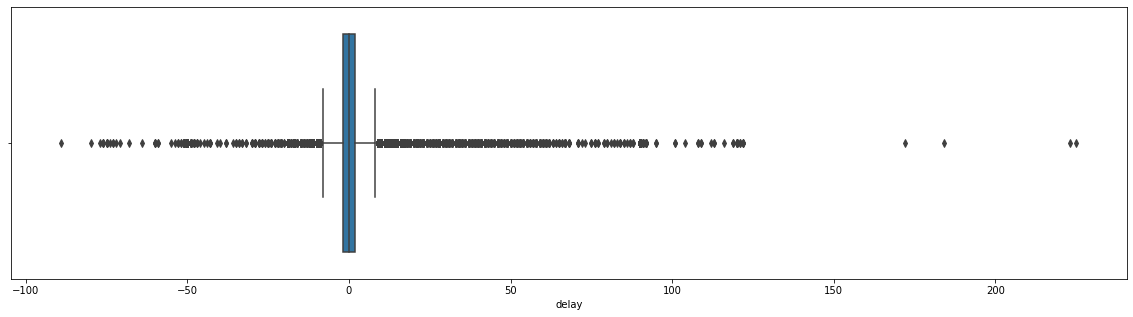

In [47]:
#visualize the distribution of quantitative data of delays
plt.figure(figsize=(20,5))
sns.boxplot(x=train['delay'])

3.555794148152008


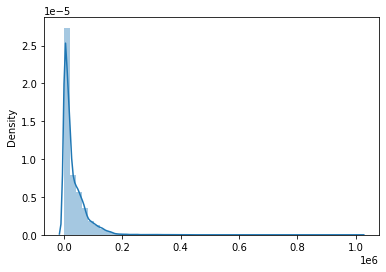

In [48]:
sns.distplot(x=train['total_open_amount'])
print(train['total_open_amount'].skew())
#total open amount is right skewed

3.8187082148193054


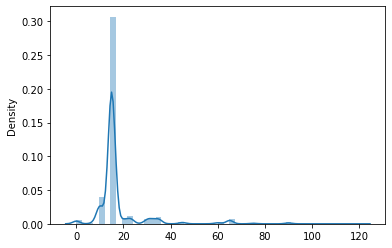

In [49]:
sns.distplot(x=train['expected_clear_days'])
print(train['expected_clear_days'].skew())
#expected clear date is right skewed

In [50]:
#standardise the total_open_amount and expected_clear_days to bring the variance at same scale
col_names = ['total_open_amount', 'expected_clear_days']
scaled_col_names = ['total_open_amount_scale', 'expected_clear_days_scale']
scaled_features = train[col_names]
scaler = StandardScaler().fit(scaled_features.values)
scaled_features = scaler.transform(scaled_features.values)
train[scaled_col_names] = scaled_features
train.drop(columns=col_names, inplace=True)
train.head(3)

,business_code,clear_date,posting_date,document_create_date,due_in_date,baseline_create_date,CA02,U001,U002,U005,U007,name_customer_enc,invoice_currency_enc,cust_payment_terms_enc,delay,business_avg_delay,cust_avg_delay,payterm_avg_delay,total_open_amount_scale,expected_clear_days_scale
0,U001,2019-01-15,2018-12-30,2018-12-30,2019-01-14,2018-12-30,0,1,0,0,0,235,1,50,1,0.239294,1.000000,1.131268,1.608396,-0.232595
1,U001,2019-01-09,2018-12-30,2018-12-29,2019-01-14,2018-12-30,0,1,0,0,0,3829,1,37,-5,0.239294,-2.507299,-1.823894,-0.657143,-0.232595
2,U001,2019-01-14,2018-12-30,2018-12-29,2019-01-14,2018-12-30,0,1,0,0,0,1964,1,22,0,0.239294,0.375000,1.241112,0.400076,-0.232595


In [51]:
#apply the same standarisation on Validation Set
scaled_features = val[col_names]
scaler = StandardScaler().fit(scaled_features.values)
scaled_features = scaler.transform(scaled_features.values)
val[scaled_col_names] = scaled_features
val.drop(columns=col_names, inplace=True)

In [52]:
#apply the same standarisation on Test Set
scaled_features = test[col_names]
scaler = StandardScaler().fit(scaled_features.values)
scaled_features = scaler.transform(scaled_features.values)
test[scaled_col_names] = scaled_features
test.drop(columns=col_names, inplace=True)

In [53]:
train.shape, val.shape, test.shape

((23413, 20), (7805, 20), (7805, 20))

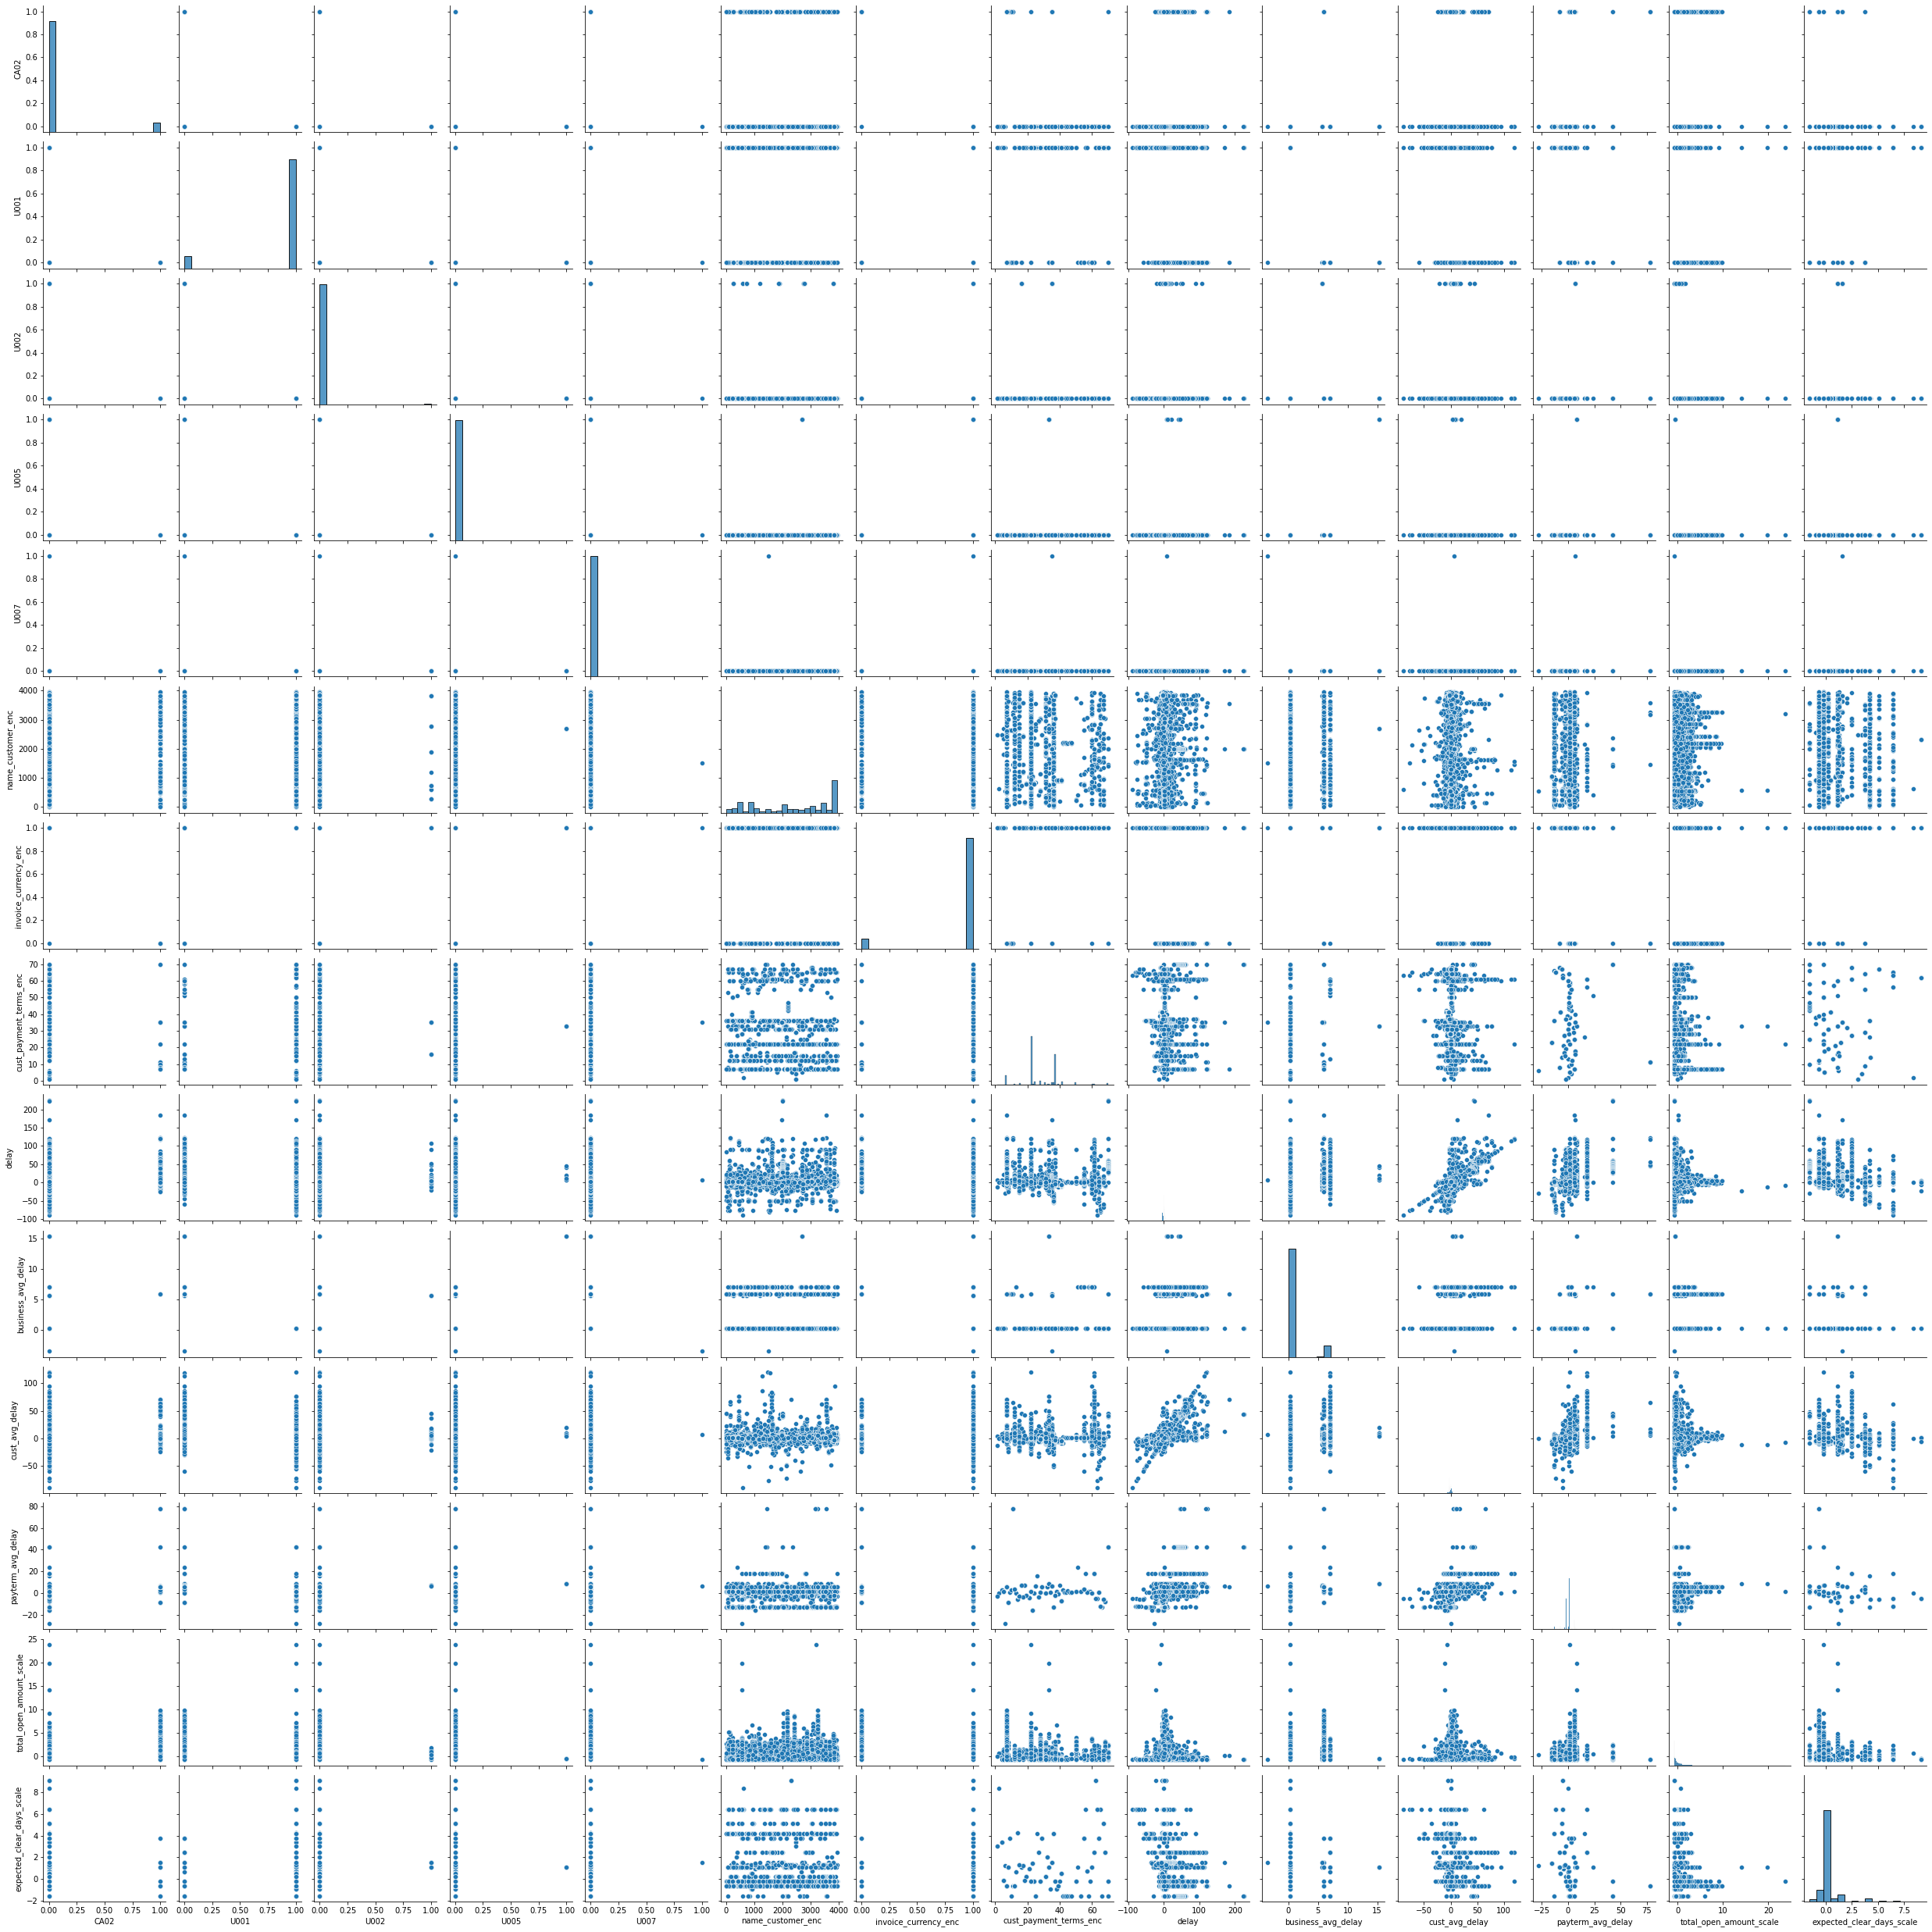

In [54]:
#visualize replationship among various columns
sns.pairplot(train, diag_kind="hist")

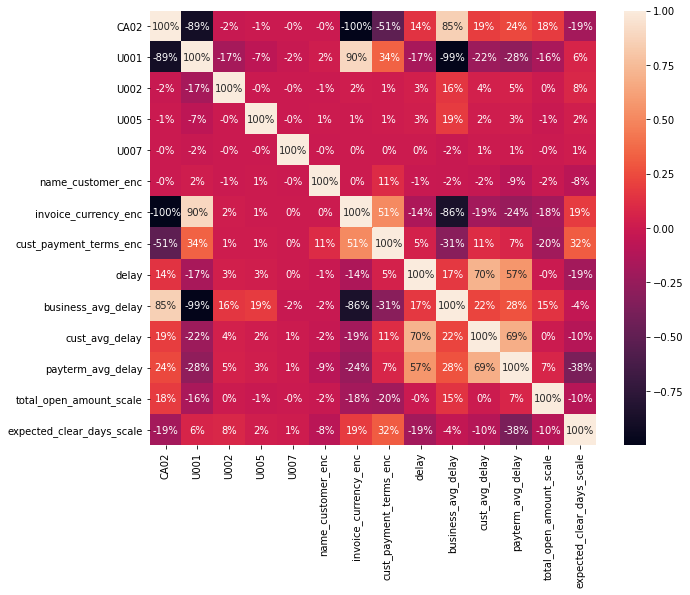

In [55]:
#Visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, fmt='.0%')

In [56]:
def handling_correlation(df,threshold=0.8):
  # creating set to hold the correlated features
  corr_features = set()
  # create the correlation matrix (default to pearson)
  corr_matrix = df.corr()
  #code for selecting all correleated features
  for i in range(len(corr_matrix .columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) >threshold:
        colname = corr_matrix.columns[i]
        corr_features.add(colname)
  return list(corr_features)

In [57]:
#finding highly corelated columns which can be removed
handling_correlation(train.copy(),0.80)

['U001', 'invoice_currency_enc', 'business_avg_delay']

In [58]:
#as invoice_currency_enc and business_avg_delay is highly corelated with U001 business code remove those features
train.drop(columns=['business_avg_delay', 'invoice_currency_enc'], inplace=True)
val.drop(columns=['business_avg_delay', 'invoice_currency_enc'], inplace=True)
test.drop(columns=['business_avg_delay', 'invoice_currency_enc'], inplace=True)
print(train.shape, val.shape, test.shape)
train.head(1)

(23413, 18) (7805, 18) (7805, 18)


,business_code,clear_date,posting_date,document_create_date,due_in_date,baseline_create_date,CA02,U001,U002,U005,U007,name_customer_enc,cust_payment_terms_enc,delay,cust_avg_delay,payterm_avg_delay,total_open_amount_scale,expected_clear_days_scale
0,U001,2019-01-15,2018-12-30,2018-12-30,2019-01-14,2018-12-30,0,1,0,0,0,235,50,1,1.0,1.131268,1.608396,-0.232595


##**MILESTONE 3: Feature Selection, Model Preparation & Prediction**

In [59]:
#Feature Selection: select nessary columns which are required during training the model
selected_columns = ['CA02','U001','U002','U005', 'U007', 'name_customer_enc', 'cust_payment_terms_enc', 
                    'cust_avg_delay', 'payterm_avg_delay', 'total_open_amount_scale', 'expected_clear_days_scale']

In [60]:
#create new dataframe which contains independent selected columns
x_train = train[selected_columns]
x_val = val[selected_columns]
x_test = test[selected_columns]
x_train.shape, x_val.shape, x_test.shape

((23413, 11), (7805, 11), (7805, 11))

In [61]:
#create target dataframe which conatins target column i.e. delay
y_train = train['delay']
y_val = val['delay']
y_test = test['delay']

In [62]:
#setting up different algorithms with different parameters to get the best algorithm to fit our model
algos = {
    'linear_regression' : {
      'model': LinearRegression(),
      'params': {
        'normalize': [True, False]
      }
    },
    'lasso': {
      'model': Lasso(),
      'params': {
        'alpha': [1,2],
        'selection': ['random', 'cyclic'],
        'normalize': [True, False]
      }
    },
    'ridge': {
      'model': Ridge(),
      'params': {
        'alpha': [1,2],
        'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
        'normalize': [True, False]
      }
    },
    'elastic_run': {
      'model': ElasticNet(),
      'params': {
        'alpha': [1,2],
        'selection': ['random', 'cyclic'],
        'normalize': [True, False]
      }
    },
    'decision_tree': {
    'model': DecisionTreeRegressor(),
      'params': {
        'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'splitter': ['best', 'random'],
        'max_leaf_nodes' : [20, 30, 40]
      }
    },
    'xgb': {
      'model': xgb.XGBRegressor(),
      'params': {
        'n_estimators': [100, 150],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'tree_method': ['exact', 'approx ', 'gpu_hist'],
        'objective': ['reg:squarederror'],
      }
    },
}
  

In [63]:
#traversing through each algorithm and their parameters to select the best model for our problem. 
scores=[]
for algo_name, config in algos.items():
      gs =  GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False)
      gs.fit(x_train,y_train)
      print(algo_name,"completed!")
      scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
      })
score_board = pd.DataFrame(scores,columns=['model','best_score','best_params'])
print(scores)
score_board

linear_regression completed!
lasso completed!
ridge completed!
elastic_run completed!
decision_tree completed!
xgb completed!
[{'model': 'linear_regression', 'best_score': 0.5159451307921256, 'best_params': {'normalize': True}}, {'model': 'lasso', 'best_score': 0.5096765274827284, 'best_params': {'alpha': 1, 'normalize': False, 'selection': 'cyclic'}}, {'model': 'ridge', 'best_score': 0.5161357574477228, 'best_params': {'alpha': 2, 'normalize': False, 'solver': 'cholesky'}}, {'model': 'elastic_run', 'best_score': 0.5111081550285153, 'best_params': {'alpha': 1, 'normalize': False, 'selection': 'cyclic'}}, {'model': 'decision_tree', 'best_score': 0.5347088329614645, 'best_params': {'criterion': 'mae', 'max_leaf_nodes': 30, 'splitter': 'best'}}, {'model': 'xgb', 'best_score': 0.560957855916027, 'best_params': {'booster': 'gbtree', 'n_estimators': 100, 'objective': 'reg:squarederror', 'tree_method': 'exact'}}]


,model,best_score,best_params
0,linear_regression,0.515945,{'normalize': True}
1,lasso,0.509677,"{'alpha': 1, 'normalize': False, 'selection': ..."
2,ridge,0.516136,"{'alpha': 2, 'normalize': False, 'solver': 'ch..."
3,elastic_run,0.511108,"{'alpha': 1, 'normalize': False, 'selection': ..."
4,decision_tree,0.534709,"{'criterion': 'mae', 'max_leaf_nodes': 30, 'sp..."
5,xgb,0.560958,"{'booster': 'gbtree', 'n_estimators': 100, 'ob..."


In [64]:
#Implementing the final model based on the higher score from GridSearchCV with additional hypertuning.
model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    colsample_bytree = 0.5,
    learning_rate = 0.02,
    max_depth = 8,
    min_child_weight = 5,
    n_estimators = 170,
    subsample = 0.09,
    tree_method = 'approx',
    gamma=0.4,
)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=8, min_child_weight=5, missing=None, n_estimators=170,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.09, tree_method='approx',
             verbosity=1)

In [65]:
#predicting and checking the model's efficiency on validation set
y_val_pred = model.predict(x_val)
acc_val = model.score(x_val,y_val)
print("Accuracy:",acc_val*100,'%')
print("MSE:", mean_squared_error(y_val, y_val_pred))
print("RMSE:", mean_squared_error(y_val, y_val_pred, squared=False))
print("R2 Score:", r2_score(y_val, y_val_pred))

Accuracy: 63.93568444666728 %
MSE: 25.005449179399438
RMSE: 5.000544888249624
R2 Score: 0.6393568444666728


In [66]:
#predicting and checking the model's efficiency on validation set
y_test_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)
print("Accuracy:",acc_test*100,'%')
print("MSE:", mean_squared_error(y_test, y_test_pred))
print("RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_test_pred))

Accuracy: 53.634139301744476 %
MSE: 38.933784051165794
RMSE: 6.239694227377315
R2 Score: 0.5363413930174448


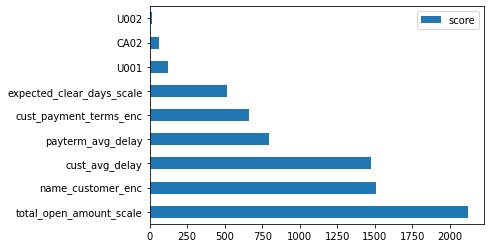

In [67]:
#visualise importance of each feature. 
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

importance_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
importance_score.plot(kind='barh')

###**Predictions on Main Test**

In [68]:
main_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200799367,MCL trust,NaN,2020.0,1.930797e+09,2020-04-17,20200416,20200417,20200502.0,USD,RV,1.0,NaN,47679.60,20200417.0,NAA8,1.930797e+09,1.0
1,U001,0200771157,WEIS corp,NaN,2020.0,1.930664e+09,2020-03-18,20200318,20200318,20200402.0,USD,RV,1.0,NaN,27945.34,20200318.0,NAA8,1.930664e+09,1.0
2,U001,0200762301,C&S WH associates,NaN,2020.0,1.930794e+09,2020-04-15,20200416,20200415,20200430.0,USD,RV,1.0,NaN,94008.28,20200415.0,NAC6,1.930794e+09,1.0
3,U001,0200772595,SAFEW corp,NaN,2020.0,1.930720e+09,2020-03-31,20200330,20200331,20200415.0,USD,RV,1.0,NaN,2925.72,20200331.0,NAA8,1.930720e+09,1.0
4,U001,0200762950,HAR trust,NaN,2020.0,1.930777e+09,2020-04-13,20200411,20200413,20200428.0,USD,RV,1.0,NaN,109178.44,20200413.0,NAA8,1.930777e+09,1.0


Data Preprocessing Steps Same As Train

In [69]:
#converts date columns to standard datetime datadtype
main_test['clear_date']= pd.to_datetime(main_test['clear_date'])
main_test['posting_date'] = pd.to_datetime(main_test['posting_date'])
main_test['document_create_date'] = pd.to_datetime(main_test['document_create_date'], format="%Y%m%d")
main_test['document_create_date.1'] = pd.to_datetime(main_test['document_create_date.1'], format="%Y%m%d")
main_test['due_in_date'] = pd.to_datetime(main_test['due_in_date'], format="%Y%m%d")
main_test['baseline_create_date'] = pd.to_datetime(main_test['baseline_create_date'], format="%Y%m%d")

In [70]:
main_test.shape

(10000, 19)

In [71]:
#remove duplicate rows
main_test.drop_duplicates(inplace=True)
main_test.shape

(9696, 19)

In [72]:
#removing the outlier of due date of invoice being less than then document create date of invoice (not possible) 
main_test = main_test[~(main_test['document_create_date']>main_test['due_in_date'])]
main_test.shape

(9657, 19)

In [73]:
#sort the dataset in ascending order of the posting date of invoice
main_test.sort_values(by=['posting_date'],  inplace=True)
main_test.reset_index(inplace=True, drop=True)

Feature Engineering Steps Same As Train

In [74]:
#calculating number of days from baseline_create_date to due_in_date provided.
main_test['expected_clear_days'] = (main_test['due_in_date'].sub(main_test['baseline_create_date'], axis=0)).dt.days

In [75]:
#As there are only 6 unique values we can perform one hot encoding technique on business code column
business_dummies_test = pd.get_dummies(main_test.business_code)
main_test = pd.concat([main_test, business_dummies_test], axis='columns')
main_test.drop(columns=['U013'], inplace=True)
main_test['U007'] = 0

In [76]:
main_test['name_customer_enc'] = name_cust_encoder.fit_transform(main_test['name_customer'])
main_test["invoice_currency_enc"] = invoice_curr_encoder.fit_transform(main_test["invoice_currency"])
main_test["cust_payment_terms_enc"] = cust_payterm_encoder.fit_transform(main_test["cust_payment_terms"])

In [77]:
#mapping each average delays in the dataset
main_test['business_avg_delay'] = main_test['business_code'].map(business_delay_dict)
main_test['cust_avg_delay'] = main_test['name_customer_enc'].map(cust_delay_dict)
main_test['payterm_avg_delay'] = main_test['cust_payment_terms_enc'].map(payterm_delay_dict)

In [78]:
#standardise the total_open_amount and expected_clear_days to bring the variance at same scale
col_names = ['total_open_amount', 'expected_clear_days']
scaled_col_names = ['total_open_amount_scale', 'expected_clear_days_scale']
scaled_features = main_test[col_names]
scaler = StandardScaler().fit(scaled_features.values)
scaled_features = scaler.transform(scaled_features.values)
main_test[scaled_col_names] = scaled_features

In [79]:
#predict the delays using your model
main_test_delay = model.predict(main_test[selected_columns])
main_test['delay'] = main_test_delay

In [80]:
main_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,expected_clear_days,CA02,U001,U002,U005,U007,name_customer_enc,invoice_currency_enc,cust_payment_terms_enc,business_avg_delay,cust_avg_delay,payterm_avg_delay,total_open_amount_scale,expected_clear_days_scale,delay
0,U001,0200769623,WAL-MAR co,NaT,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,1322.22,2020-02-27,NAH4,1.930577e+09,1.0,15,0,1,0,0,0,1646,1,26,0.239294,26.666667,16.000000,-0.859005,-0.197258,22.868883
1,U001,0200705742,DOT co,NaT,2020.0,1.930576e+09,2020-02-27,2020-02-26,2020-02-27,2020-04-01,USD,RV,1.0,NaN,84757.81,2020-02-27,NAAW,1.930576e+09,1.0,34,0,1,0,0,0,477,1,13,0.239294,3.000000,0.000000,1.445912,1.721396,1.285027
2,U001,0200704045,RA co,NaT,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,32336.71,2020-02-27,NAA8,1.930577e+09,1.0,15,0,1,0,0,0,1179,1,12,0.239294,0.000000,3.715116,-0.002227,-0.197258,0.786605
3,U001,0200794332,COST in,NaT,2020.0,1.930571e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,30220.01,2020-02-27,NAAX,1.930571e+09,1.0,15,0,1,0,0,0,349,1,14,0.239294,-4.666667,-6.000000,-0.060701,-0.197258,-5.167422
4,U001,0200762301,C&S WH systems,NaT,2020.0,1.930574e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,23009.92,2020-02-27,NAC6,1.930574e+09,1.0,15,0,1,0,0,0,262,1,17,0.239294,1.000000,-3.675676,-0.259880,-0.197258,-0.413354


In [81]:
#add your delays to your due_in_date to get clear_date/payment date
len = main_test.shape[0]
for i in range(len):
  main_test['clear_date'][i] = (main_test['due_in_date'][i] + pd.DateOffset(days=main_test['delay'][i])).strftime('%Y-%m-%d')
main_test.head(10)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,expected_clear_days,CA02,U001,U002,U005,U007,name_customer_enc,invoice_currency_enc,cust_payment_terms_enc,business_avg_delay,cust_avg_delay,payterm_avg_delay,total_open_amount_scale,expected_clear_days_scale,delay
0,U001,0200769623,WAL-MAR co,2020-04-04,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,1322.22,2020-02-27,NAH4,1.930577e+09,1.0,15,0,1,0,0,0,1646,1,26,0.239294,26.666667,16.000000,-0.859005,-0.197258,22.868883
1,U001,0200705742,DOT co,2020-04-02,2020.0,1.930576e+09,2020-02-27,2020-02-26,2020-02-27,2020-04-01,USD,RV,1.0,NaN,84757.81,2020-02-27,NAAW,1.930576e+09,1.0,34,0,1,0,0,0,477,1,13,0.239294,3.000000,0.000000,1.445912,1.721396,1.285027
2,U001,0200704045,RA co,2020-03-13,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,32336.71,2020-02-27,NAA8,1.930577e+09,1.0,15,0,1,0,0,0,1179,1,12,0.239294,0.000000,3.715116,-0.002227,-0.197258,0.786605
3,U001,0200794332,COST in,2020-03-07,2020.0,1.930571e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,30220.01,2020-02-27,NAAX,1.930571e+09,1.0,15,0,1,0,0,0,349,1,14,0.239294,-4.666667,-6.000000,-0.060701,-0.197258,-5.167422
4,U001,0200762301,C&S WH systems,2020-03-12,2020.0,1.930574e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,23009.92,2020-02-27,NAC6,1.930574e+09,1.0,15,0,1,0,0,0,262,1,17,0.239294,1.000000,-3.675676,-0.259880,-0.197258,-0.413354
5,U001,0200769623,WAL-MAR llc,2020-03-14,2020.0,1.930555e+09,2020-02-27,2020-02-21,2020-02-27,2020-03-13,USD,RV,1.0,NaN,5097.55,2020-02-27,NAH4,1.930555e+09,1.0,15,0,1,0,0,0,1651,1,26,0.239294,0.000000,16.000000,-0.754711,-0.197258,1.887899
6,U001,0200769623,WAL-MAR co,2020-03-28,2020.0,1.930571e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,55405.24,2020-02-27,NAH4,1.930571e+09,1.0,15,0,1,0,0,0,1646,1,26,0.239294,26.666667,16.000000,0.635044,-0.197258,15.180893
7,U001,0200706844,WINC,2020-03-15,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,73337.57,2020-02-27,NAA8,1.930577e+09,1.0,15,0,1,0,0,0,1692,1,12,0.239294,1.666667,3.715116,1.130427,-0.197258,2.022404
8,U001,0200759878,SA corporation,2020-03-15,2020.0,1.930575e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,39098.70,2020-02-27,NAH4,1.930575e+09,1.0,15,0,1,0,0,0,1254,1,26,0.239294,1.000000,16.000000,0.184574,-0.197258,2.187845
9,U001,0200769623,WAL-MAR in,2020-03-13,2020.0,1.930574e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,63313.93,2020-02-27,NAH4,1.930574e+09,1.0,15,0,1,0,0,0,1650,1,26,0.239294,0.000000,16.000000,0.853523,-0.197258,0.559091


In [83]:
#select your final columns to save
final_df = main_test.loc[:, 'business_code' : 'isOpen']
final_df['delay'] = main_test['delay']
final_df

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
0,U001,0200769623,WAL-MAR co,2020-04-04,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,1322.22,2020-02-27,NAH4,1.930577e+09,1.0,22.868883
1,U001,0200705742,DOT co,2020-04-02,2020.0,1.930576e+09,2020-02-27,2020-02-26,2020-02-27,2020-04-01,USD,RV,1.0,NaN,84757.81,2020-02-27,NAAW,1.930576e+09,1.0,1.285027
2,U001,0200704045,RA co,2020-03-13,2020.0,1.930577e+09,2020-02-27,2020-02-27,2020-02-27,2020-03-13,USD,RV,1.0,NaN,32336.71,2020-02-27,NAA8,1.930577e+09,1.0,0.786605
3,U001,0200794332,COST in,2020-03-07,2020.0,1.930571e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,30220.01,2020-02-27,NAAX,1.930571e+09,1.0,-5.167422
4,U001,0200762301,C&S WH systems,2020-03-12,2020.0,1.930574e+09,2020-02-27,2020-02-26,2020-02-27,2020-03-13,USD,RV,1.0,NaN,23009.92,2020-02-27,NAC6,1.930574e+09,1.0,-0.413354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9652,U001,0100036318,TFC,2020-05-19,2020.0,1.930907e+09,2020-05-15,2020-05-15,2020-05-15,2020-05-25,USD,RV,1.0,NaN,28778.75,2020-05-15,NA10,1.930907e+09,1.0,-5.623387
9653,U001,200956366,RICH co,2020-06-04,2020.0,1.930902e+09,2020-05-18,2020-05-14,2020-05-18,2020-06-02,USD,RV,1.0,NaN,41540.40,2020-05-18,NAA8,1.930902e+09,1.0,2.394048
9654,U001,0200765011,MAINES corp,2020-06-01,2020.0,1.930918e+09,2020-05-19,2020-05-19,2020-05-19,2020-06-03,USD,RV,1.0,NaN,27984.87,2020-05-19,NAA8,1.930918e+09,1.0,-1.001907
9655,U001,100026809,PRES corporation,2020-05-30,2020.0,1.930916e+09,2020-05-19,2020-05-19,2020-05-19,2020-05-29,USD,RV,1.0,NaN,402.50,2020-05-19,NA10,1.930916e+09,1.0,1.814050


In [85]:
#save it in a csv file
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/final_csv.csv', index=False)

In [86]:
# Save the final model as a pickle file 
import joblib 
joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/saved_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/saved_model.pkl']